<h3>Batik image classification using CNN</h3>
<p>Author: HendryHB</p>

In [40]:
from google.colab import drive  # for google colab
import zipfile  # for google colab
import sys
import numpy as np
import os
from PIL import Image
import pandas as pd
import tensorflow as tf
import itertools
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D, Dense, MaxPooling2D, Dropout, Flatten, BatchNormalization, Activation
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, Callback, ReduceLROnPlateau
from tensorflow.keras import layers, Model

from keras.utils import to_categorical
from keras.models import load_model
from keras.preprocessing.image import array_to_img

from sklearn.metrics import classification_report
from sklearn.metrics import precision_score, accuracy_score, confusion_matrix

%matplotlib inline
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns
np.random.seed(42)

In [3]:
drive.mount('/content/drive')  # for google colab

In [4]:
with zipfile.ZipFile("/content/drive/MyDrive/raw_batik_v2.1.zip") as zip_ref:  # for colab
  zip_ref.extractall("./")

# Constants

In [41]:
IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224
COLOR_CHANNELS = 3
BATCH_SIZE = 32

# Data Gathering

In [45]:
# Directory containing the data - fetching dataset from google drive
DATA_DIR = "/content/raw_batik_v2.1.zip"

common_datagen = ImageDataGenerator(
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    fill_mode='constant',
    rescale=1./255 
)

# Set up data generators for training, validation, and testing
train_generator = common_datagen.flow_from_directory(
    directory=os.path.join(DATA_DIR, "train"),
    target_size=(IMAGE_HEIGHT, IMAGE_WIDTH),  # Set the target image size
    batch_size=BATCH_SIZE,
    color_mode='rgb', # Set color mode to RGB
    class_mode='categorical'  # For multi classes
)

test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
    directory=os.path.join(DATA_DIR, "test"),
    target_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE,
    color_mode='rgb', # Set color mode to RGB
    class_mode='categorical'
)


Found 640 images belonging to 20 classes.
Found 160 images belonging to 20 classes.


# Data Exploration

## Train Dataset

#### `.n` is an attribute to the total count of images found and `.num_classes` is the number of subdirectories found (classes)

In [47]:
x_train_images = train_generator.n
y_train_classes = train_generator.num_classes
print(f"Number of images: {train_generator.n}, Number of classes:{train_generator.num_classes}")

Number of images: 640, Number of classes:20


In [44]:
x_train_all = []
y_train_all = []

# Looping, check: // BATCH_SIZE or + 1
for _ in range(x_train_images // BATCH_SIZE ):
    x_batch, y_batch = next(train_generator)
    x_train_all.append(x_batch)
    y_train_all.append(y_batch)

# Concatenate
x_train = np.concatenate(x_train_all, axis=0)
y_train = np.concatenate(y_train_all, axis=0)

# Display the shapes of x and y_train
print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)

x_train shape: (640, 224, 224, 3)
y_train shape: (640, 20)


In [48]:
# Get class indices and create a reverse mapping
x_train_class_indices = train_generator.class_indices
y_train_index_to_class = {v: k for k, v in x_train_class_indices.items()}

In [51]:
# Define train labels that could be reused on later stage
train_labels = [y_train_index_to_class[idx] for idx in range(len(y_train_index_to_class))]
print("Class names:", train_labels)

Class names: ['Aceh_Pintu_Aceh', 'Bali_Barong', 'Bali_Merak', 'DKI_Ondel_Ondel', 'JawaBarat_Megamendung', 'JawaTimur_Pring', 'Kalimantan_Dayak', 'Lampung_Gajah', 'Madura_Mataketeran', 'Maluku_Pala', 'NTB_Lumbung', 'Papua_Asmat', 'Papua_Cendrawasih', 'Papua_Tifa', 'Solo_Parang', 'SulawesiSelatan_Lontara', 'SumateraBarat_Rumah_Minang', 'SumateraUtara_Boraspati', 'Yogyakarta_Kawung', 'Yogyakarta_Parang']


## Test Dataset

In [52]:
x_test_images = test_generator.n
y_test_classes = test_generator.num_classes
print(f"Number of images: {test_generator.n}, Number of classes:{test_generator.num_classes}")

Number of images: 160, Number of classes:20


In [53]:
x_test_all = []
y_test_all = []

# Looping, check: // BATCH_SIZE or + 1
for _ in range(x_test_images // BATCH_SIZE):
    x_test_batch, y_test_batch = next(test_generator)
    x_test_all.append(x_test_batch)
    y_test_all.append(y_test_batch)

# Concatenate
x_test = np.concatenate(x_test_all, axis=0)
y_test = np.concatenate(y_test_all, axis=0)

# Display the shapes of x and y_train
print("x_test shape:", x_test.shape)
print("y_test shape:", y_test.shape)

x_test shape: (160, 224, 224, 3)
y_test shape: (160, 20)


In [54]:
# Get class indices and create a reverse mapping
x_test_class_indices = test_generator.class_indices
y_test_index_to_class = {v: k for k, v in x_test_class_indices.items()}

In [55]:
# Define test labels that could be reused on later stage
test_labels = [y_test_index_to_class[idx] for idx in range(len(y_test_index_to_class))]
print("Class names:", test_labels)

Class names: ['Aceh_Pintu_Aceh', 'Bali_Barong', 'Bali_Merak', 'DKI_Ondel_Ondel', 'JawaBarat_Megamendung', 'JawaTimur_Pring', 'Kalimantan_Dayak', 'Lampung_Gajah', 'Madura_Mataketeran', 'Maluku_Pala', 'NTB_Lumbung', 'Papua_Asmat', 'Papua_Cendrawasih', 'Papua_Tifa', 'Solo_Parang', 'SulawesiSelatan_Lontara', 'SumateraBarat_Rumah_Minang', 'SumateraUtara_Boraspati', 'Yogyakarta_Kawung', 'Yogyakarta_Parang']


# Plotting Images

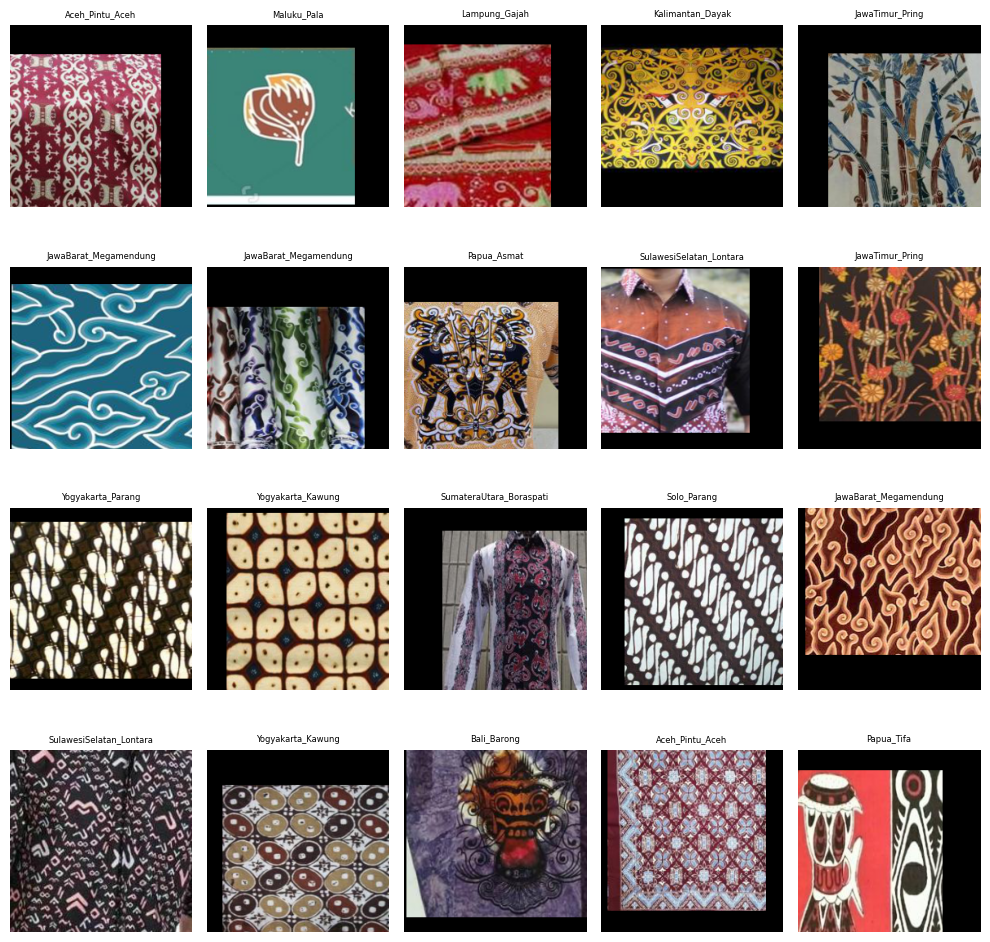

In [19]:
# Fetch a batch of images and labels from the generator
x_train_images, y_train_labels = next(train_generator)

# Shuffle the images and labels
shuffle_indices = np.random.permutation(x_train_images.shape[0])
x_train_images = x_train_images[shuffle_indices]
y_train_labels = y_train_labels[shuffle_indices]

# Get class names from the train labels using the train_labels list
class_names = [train_labels[np.argmax(label)] for label in y_train_labels]

fig, axes = plt.subplots(4, 5, figsize=(10, 10))
axes = axes.ravel()

# Plot images with their corresponding class names
for i in range(20):
    axes[i].imshow(x_train_images[i])
    axes[i].set_title(class_names[i], fontsize=6)
    axes[i].axis('off')

plt.tight_layout()
plt.show()

# Modelling

## Self-Defined CNN

In [20]:
# Set the global random seed
tf.random.set_seed(42)
input_layer = tf.keras.layers.Input(shape=(IMAGE_WIDTH, IMAGE_HEIGHT, COLOR_CHANNELS))

# block 1
conv1 = tf.keras.layers.Conv2D(32, kernel_size=(3, 3),
                               activation='relu', padding='same')(input_layer)
pool1 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv1)
norm1 = tf.keras.layers.BatchNormalization(axis = -1)(pool1)
drop1 = tf.keras.layers.Dropout(rate=0.2)(norm1)

# block 2
conv2 = tf.keras.layers.Conv2D(64, kernel_size=(3, 3),
                               activation='relu', padding='same')(drop1)
pool2 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv2)
norm2 = tf.keras.layers.BatchNormalization(axis = -1)(pool2)
drop2 = tf.keras.layers.Dropout(rate=0.2)(norm2)

# block 3
conv3 = tf.keras.layers.Conv2D(64, kernel_size=(3, 3),
                               activation='relu', padding='same')(drop2)
pool3 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv3)
norm3 = tf.keras.layers.BatchNormalization(axis = -1)(pool3)
drop3 = tf.keras.layers.Dropout(rate=0.2)(norm3)

# block 4
conv4 = tf.keras.layers.Conv2D(128, kernel_size=(3, 3),
                               activation='relu', padding='same')(drop3)
pool4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv4)
norm4 = tf.keras.layers.BatchNormalization(axis = -1)(pool4)
drop4 = tf.keras.layers.Dropout(rate=0.2)(norm4)

# block 5
conv5 = tf.keras.layers.Conv2D(128, kernel_size=(3, 3),
                               activation='relu', padding='same')(drop4)
pool5 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv5)
norm5 = tf.keras.layers.BatchNormalization(axis = -1)(pool5)
drop5 = tf.keras.layers.Dropout(rate=0.2)(norm5)

flat = tf.keras.layers.Flatten()(drop5)  #Flatten the matrix to get it ready for dense:).

# Dense Layers
hidden1 = tf.keras.layers.Dense(64, activation='relu')(flat)
norm6 = tf.keras.layers.BatchNormalization(axis = -1)(hidden1)
drop6 = tf.keras.layers.Dropout(rate=0.2)(norm6)

output_layer = tf.keras.layers.Dense(20, activation='softmax')(drop6)

model = tf.keras.models.Model(inputs=input_layer, outputs=output_layer)

print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 32)      0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 112, 112, 32)      128       
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 112, 112, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      18496 

In [39]:
type(model)

keras.src.engine.functional.Functional

# Compile

In [25]:
model.compile(optimizer = 'adam',
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

# Training - Fit Model

In [26]:
%%time
EPOCHS = 150
                                  
# Define EarlyStop
early_stop = EarlyStopping(monitor='val_loss', patience=100, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=100, min_lr=1e-6)

# Define callbacks
callbacks = [early_stop, reduce_lr]

# Train the model
history = model.fit(train_generator,
                               verbose=1,
                               epochs=EPOCHS,
                               callbacks=callbacks,
                               validation_data=(test_generator))

## Plotting Accuracy and Loss Graphs 

In [38]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

# Plot accuracy
plt.plot(epochs, acc, 'g')
plt.plot(epochs, val_acc, 'orange')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Training accuracy', 'Validation accuracy'], loc='upper left')
plt.show()

# Plot loss
plt.plot(epochs, loss, 'g')
plt.plot(epochs, val_loss, 'orange')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Training loss', 'Validation loss'], loc='upper left')
plt.title('Training and Validation Loss')
plt.show()

# Evaluation and Prediction

In [28]:
np.set_printoptions(precision=3)
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test loss : {test_loss:0.3} and the test accuracy: {test_accuracy:0.2%}")

5/5 [==============================] - 18s 3s/step - loss: 1.9566 - accuracy: 0.7063
Test loss : 1.96 and the test accuracy: 70.63%


In [29]:
predictions = model.predict(test_generator)
y_test_labels = np.argmax(y_test, axis=1)

5/5 [==============================] - 17s 3s/step


In [33]:
y_pred = predictions.argmax(axis=1)
classify_report = classification_report(y_test_labels, y_pred, target_names=test_labels)
print(classify_report)

                            precision    recall  f1-score   support

           Aceh_Pintu_Aceh       0.00      0.00      0.00         8
               Bali_Barong       0.12      0.12      0.12         8
                Bali_Merak       0.22      0.25      0.24         8
           DKI_Ondel_Ondel       0.00      0.00      0.00         8
     JawaBarat_Megamendung       0.17      0.12      0.14         8
           JawaTimur_Pring       0.00      0.00      0.00         8
          Kalimantan_Dayak       0.00      0.00      0.00         8
             Lampung_Gajah       0.08      0.12      0.10         8
        Madura_Mataketeran       0.00      0.00      0.00         8
               Maluku_Pala       0.00      0.00      0.00         8
               NTB_Lumbung       0.00      0.00      0.00         8
               Papua_Asmat       0.00      0.00      0.00         8
         Papua_Cendrawasih       0.00      0.00      0.00         8
                Papua_Tifa       0.00      0.00

<h3>Feel Free to Fine-tune</h3>
<p>By fine-tuning the model, there is a chance that the accuracy performance will improve, and not only accuracy but also the training and validation loss curves will converge. It is recommended to explore and perform this adjustment. Indeed, there is a need to perform dataset augmentation for all. Below are the images from the fine-tuned models that generate better classification reports.</p>
<img src="https://github.com/hendryhb/kecakbali/blob/main/classy_report.png?raw=true">